In [28]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cvx
from scipy import optimize
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16, 9)

In [2]:
# Importing datasets
Xtrain = np.genfromtxt('../HW5-6/Xtrain.csv', delimiter = ',')
Xtest = np.genfromtxt('../HW5-6/Xtest.csv', delimiter = ',')
ytrain = np.genfromtxt('../HW5-6/ytrain.csv', delimiter = ',')
ytest = np.genfromtxt('../HW5-6/ytest.csv', delimiter = ',')

# Log transforming inputs due to small magnitude on the tails
Xtrain = np.log(Xtrain + 0.1)
Xtest = np.log(Xtest + 0.1)

# Transforming training and testing labels from {1, 0} to {1, -1}
for i in range(len(ytrain)):
    if ytrain[i] == 0:
        ytrain[i] = -1
for i in range(len(ytest)):
    if ytest[i] == 0:
        ytest[i] = -1

In [3]:
def L(w):
    tot = 0
    for i in range(Xtrain.shape[0]):
        tot += np.log(1 + np.exp(-ytrain[i]*w.T@Xtrain[i,:]))
    return tot
def sig(a):
    return 1/(1 + np.exp(-a))
def grad_L(w):
    mu = np.empty(Xtrain.shape[0])
    for i in range(Xtrain.shape[0]):
        t = sig(ytrain[i]*w.T@Xtrain[i,:])
        mu[i] = t
    return -Xtrain.T@(ytrain * (1 - mu))

In [4]:
def gradientDescentSolver(x_0, f, grad_f, lam, steps, flag, rho, c, linesearch_flag):

    # Linesearch
    if linesearch_flag == 0:

        # Defining arrays and constants
        tol = 1e-4
        error = 10 # arbitrary to start
        x_n = np.array(x_0)
        error_arr = []
        i = 0

        # Gradient descent loop
        while error > tol:
            i += 1
            x_prev = x_n

            # updating weight (position)
            x_n = x_n - lam*grad_f(x_n)

            # early stopping
            if (i == steps) & (flag == 1):
                return x_n, error_arr, i

            # L-2 norm for error between points
            error = np.linalg.norm(x_n - x_prev)
            if i % 1000 == 0:
                print(f'Step: {i} | Error: {error}')
            error_arr.append(error)
            
        return x_n, error_arr, i

    # Gradient Descent
    else:
        t = 0.5 #optimal?
        p_k = -grad_f(x_0)
        while f(x_0 + t*p_k) > f(x_0) + c*t*grad_f(x_0)@p_k: #armijo condition
            t = rho*t

        return t

# Problem 1

## Stochastic Gradient Descent

In [6]:
# Initialize random starting point and learning rate
w = np.random.rand(Xtrain.shape[1])
s_norm = np.linalg.norm(Xtrain,2)**2
lam = 10/s_norm #found by checking results via input
rho = 0.9
c = 0.5

# defining functions as parameters
func = L
grad = grad_L

# Pass to gradient solver (either stopping at n steps or going until tolerance)
steps = 200
step_flag = 0
w_trained, err, i = gradientDescentSolver(w, func, grad, lam, steps, step_flag, rho, c, 0)

Step: 1000 | Error: 0.00087823066786953
Step: 2000 | Error: 0.0004745197813815834
Step: 3000 | Error: 0.00032059987216244597
Step: 4000 | Error: 0.00024148655641693766
Step: 5000 | Error: 0.00019436210739875908
Step: 6000 | Error: 0.00016341757985523144
Step: 7000 | Error: 0.00014159995603729857
Step: 8000 | Error: 0.00012536241639653144
Step: 9000 | Error: 0.00011276185912924081
Step: 10000 | Error: 0.00010266010205556709


## Nesterov Accelerated Gradient Descent

In [11]:
def NAG(x_0, grad_f, lam, steps, early_stop_flag):

    # Defining arrays and constants
    tol = 1e-4
    error = 10 # arbitrary to start

    # specific constant and initalization to NAG
    V_t = 0
    beta = 0.9

    # starting point and error for graphing loss
    x_n = np.array(x_0)
    error_arr = []
    i = 0

    # Gradient descent loop
    while error > tol:
        i += 1
        x_prev = x_n
        
        # point based off history (looking ahead)
        x_look_ahead = x_n - lam*V_t

        # Use momentum but at the point ahead
        V_t = beta*V_t + (1 - beta)*grad_f(x_look_ahead)

        # Update current point
        x_n = x_n - lam*V_t

        # early stopping
        if (i == steps) & (early_stop_flag == 1):
            return x_n, error_arr, i

        # L-2 norm for error between points
        error = np.linalg.norm(x_n - x_prev)
        if i % 1000 == 0:
            print(f'Step: {i} | Error: {error}')
        error_arr.append(error)

    return x_n, error_arr, i

In [13]:
# Initialize random starting point and learning rate
w = np.random.rand(Xtrain.shape[1])
s_norm = np.linalg.norm(Xtrain,2)**2
lam = 10/s_norm #found by checking results via input

# defining functions as parameters
grad = grad_L

# Pass to NAG solver (either stopping at n steps or going until tolerance)
steps = 200
early_stop_flag = 0
w_trained_NAG, err_NAG, i_NAG = NAG(w, grad, lam, steps, early_stop_flag)

Step: 1000 | Error: 0.0009644678736890836
Step: 2000 | Error: 0.0004958967547160312
Step: 3000 | Error: 0.0003247126753045982
Step: 4000 | Error: 0.00023633732086021208
Step: 5000 | Error: 0.00018453408790899725
Step: 6000 | Error: 0.0001516305378001598
Step: 7000 | Error: 0.00012941323620685436
Step: 8000 | Error: 0.00011361871270838898
Step: 9000 | Error: 0.00010187387149237896


## Nelder-Mead Simplex Method

In [22]:
# Initialize random starting point and learning rate
w = np.random.rand(Xtrain.shape[1])

# defining functions as parameters
func = L

# Pass to Nelder-Mead simplex method (derivative-free)
Mead = optimize.fmin(func, w)

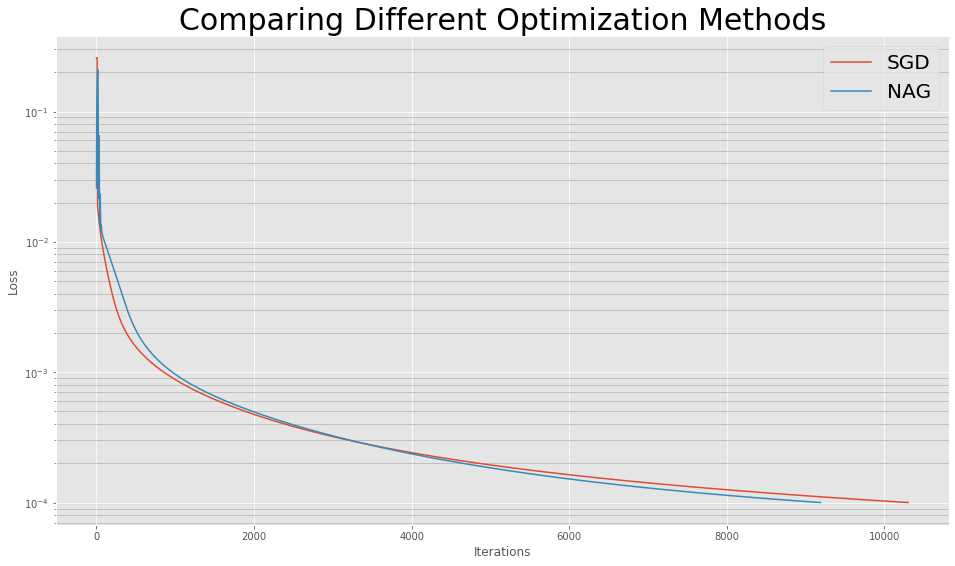

In [45]:
plt.semilogy(err, label='SGD')
plt.semilogy(err_NAG, label='NAG')
# plt.semilogy()
plt.title('Comparing Different Optimization Methods', fontsize=30)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid(True, color='black', which='minor', alpha=0.2)
plt.legend(fontsize=20)

# Problem 2

In [ ]:
def prox_descent():
    pass